# Data Pre-processing

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.windows import Window

from osgeo import gdal
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random

## Further Data Annotation

In [2]:
input_file = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\dop20rgbi_32_656_5818_2_st_2020.tif"
src = rasterio.open(input_file)

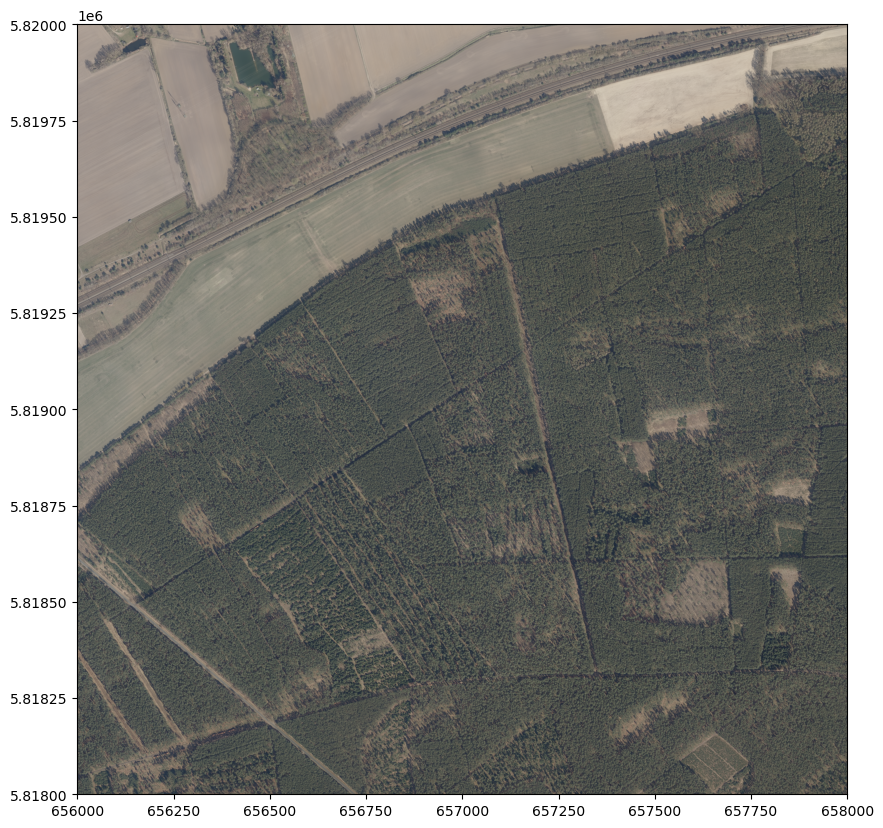

In [3]:
plt.figure(figsize=(10,10))
show(src)
plt.show()

In [6]:
file_path = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Saxony-Anhalt-Forests\\Rueckegassen\\annotated_gassen.gpkg"
vector_data = gpd.read_file(file_path)

fig, ax = plt.subplots(figsize=(100, 100))
vector_data.plot(ax=ax)

plt.show()

In [7]:
shape = 10000, 10000
#transform = rasterio.transform.from_bounds(*vector_data['geometry'].total_bounds, *shape)

transform = src.transform
crs = src.crs

In [8]:
rasterize_forest = rasterize(
    [(shape, 1) for shape in vector_data['geometry']],
    out_shape=shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8)

In [9]:
with rasterio.open(
    'rasterized-results.tif', 'w',
    driver='GTiff',
    dtype=rasterio.uint8,
    count=1,
    width=shape[0],
    height=shape[1],
    transform=transform,
    crs=crs
) as dst:
    dst.write(rasterize_forest, indexes=1)

In [89]:
# Open the GeoTiff file
with rasterio.open('D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\rasterized-results.tif') as src:
    # Read the entire image
    mask = src.read(1)
    # Get the metadata
    meta = src.meta

    # Create a new array for the modified mask
    modified_mask = np.zeros_like(mask)

    # Iterate over each pixel
    for row in range(src.height):
        for col in range(src.width):
            # Check if the pixel value is 1
            if mask[row, col] == 1:
                # Set the pixel value to 1
                modified_mask[row, col] = 1
                # Set the values of neighboring pixels
                for i in range(-5, 6):  # Adjust this range as needed
                    for j in range(-5, 6):  # Adjust this range as needed
                        new_row = row + i
                        new_col = col + j
                        if 0 <= new_row < src.height and 0 <= new_col < src.width:  # Check boundary
                            modified_mask[new_row, new_col] = 1

# Update metadata
meta['dtype'] = 'uint8'

# Write the modified mask to a new GeoTiff file
with rasterio.open('output_mask_1.tif', 'w', **meta) as dst:
    dst.write(modified_mask, 1)

## Splitting the Image

In [2]:
print(os.getcwd())

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [7]:
def split_geotiff(input_file, output_dir, tile_size):
    with rasterio.open(input_file, 'r') as src:
        width, height = src.width, src.height

        for i in range(0, width, tile_size):
            for j in range(0, height, tile_size):
                # Ensure tile size doesn't exceed image dimensions
                tile_width = min(tile_size, width - i)
                tile_height = min(tile_size, height - j)

                output_file = os.path.join(output_dir, f"output_{i}_{j}.tif")
                gdaltranString = f"gdal_translate -of GTIFF -srcwin {i} {j} {tile_width} {tile_height} {input_file} {output_file}"
                os.system(gdaltranString)

In [8]:
tile_size = 512
output_dir = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\"

split_geotiff(input_file, output_dir, tile_size)

In [12]:
mask_output_dir = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Saxony-Anhalt-Forests\\Masks"
mask_file = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Saxony-Anhalt-Forests\\Masks\\output_mask_1.tif"

split_geotiff(mask_file, mask_output_dir, tile_size)

In [13]:
image_dir = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Saxony-Anhalt-Forests\\Images"
mask_dir = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Saxony-Anhalt-Forests\\Masks"

# List all files in the directories
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

#Randomly select three images
random_images = random.sample(image_files, 3)

# Plot the images and corresponding masks
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, img_file in enumerate(random_images):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, img_file)  # Assume mask has the same filename
    with rasterio.open(img_path) as src_img, rasterio.open(mask_path) as src_mask:
        img = src_img.read()
        mask = src_mask.read()
        show(img, ax=axes[i, 0], title=f"Image {i+1}")
        axes[i, 0].axis("off")
        show(mask, ax=axes[i, 1], title=f"Mask {i+1}")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

ValueError: Sample larger than population or is negative

In [14]:
from PIL import Image
import numpy as np

# Open the PNG file
image_path = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\DeepLabV3Plus-Pytorch\\datasets\\forests\\train\\images\\89.png"
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Display the shape of the array
print("Image shape:", image_array.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Masters\\OVGU\\VII_Semester\\Thesis\\DeepLabV3Plus-Pytorch\\datasets\\forests\\train\\images\\89.png'

In [15]:
image_array

NameError: name 'image_array' is not defined

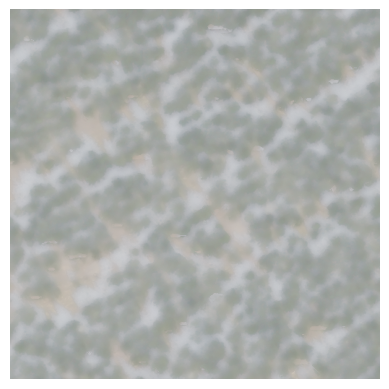

In [15]:
import matplotlib.pyplot as plt

# Drop the last dimension
    image_array_2d = image_array[..., :3]

# Display the image
plt.imshow(image_array)
plt.axis('off')  # Turn off axis
plt.show()


In [16]:
import os
import random
import shutil

def split_data(images_folder, masks_folder, train_ratio=0.75):
    # Create train and val directories
    train_dir = os.path.join(os.path.dirname(images_folder), "train")
    val_dir = os.path.join(os.path.dirname(images_folder), "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    train_dir_images = os.path.join(train_dir, "images")
    train_dir_masks = os.path.join(train_dir, "masks")
    val_dir_images = os.path.join(val_dir, "images")
    val_dir_masks = os.path.join(val_dir, "masks")
    os.makedirs(train_dir_images, exist_ok=True)
    os.makedirs(train_dir_masks, exist_ok=True)
    os.makedirs(val_dir_images, exist_ok=True)
    os.makedirs(val_dir_masks, exist_ok=True)

    # Get list of image files
    image_files = os.listdir(images_folder)
    random.shuffle(image_files)

    # Calculate number of images for train and val
    num_images = len(image_files)
    num_train = int(train_ratio * num_images)

    # Split images into train and val sets
    train_images = image_files[:num_train]
    val_images = image_files[num_train:]

    # Move images to train and val directories
    for img in train_images:
        img_src = os.path.join(images_folder, img)
        img_dst = os.path.join(train_dir_images, img)
        shutil.move(img_src, img_dst)

        # Move corresponding mask
        mask_name = img.replace(".tif", "_mask.tif")  # assuming masks have same name with _mask suffix
        mask_src = os.path.join(masks_folder, mask_name)
        mask_dst = os.path.join(train_dir_masks, mask_name)
        shutil.move(mask_src, mask_dst)

    for img in val_images:
        img_src = os.path.join(images_folder, img)
        img_dst = os.path.join(val_dir_images, img)
        shutil.move(img_src, img_dst)

        # Move corresponding mask
        mask_name = img.replace(".tif", "_mask.tif")  # assuming masks have same name with _mask suffix
        mask_src = os.path.join(masks_folder, mask_name)
        mask_dst = os.path.join(val_dir_masks, mask_name)
        shutil.move(mask_src, mask_dst)


In [17]:
# Example usage:
images_folder = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\datasets\\Data\\Saxony-Anhalt-Forests\\Images"
masks_folder = "D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\datasets\\Data\\Saxony-Anhalt-Forests\\Masks"
split_data(images_folder, masks_folder)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\datasets\\Data\\Saxony-Anhalt-Forests\\Images'